# OTMF demonstration notebook

### Imports

In [1]:
import numpy as np 
import sys 
import matplotlib.pyplot as plt
import matplotlib.image as im
import time
from PIL import Image



from scipy.ndimage import zoom
from scipy.ndimage.filters import gaussian_filter 
from scipy.ndimage.filters import median_filter 

% matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
from otmf import parameters
from otmf import gibbs_sampler as gs
from otmf import fields_tools as ft
import otmf.segmentation as sot
from otmf import parameter_estimation as pe

### Misc functions (display, ...)

In [3]:
def plot_directions(angle,pas,taille=1):
    
    S0 = angle.shape[0]
    S1 = angle.shape[1]
    
    y,x = np.ogrid[0:S0,0:S1]
 
    angle2 = angle

    deb_x = np.tile(x,(S0,1)) - taille*np.sin(angle2) 
    deb_y = np.tile(y,(1,S1)) - taille*np.cos(angle2) 
    
    fin_x = np.tile(x,(S0,1)) + taille*np.sin(angle2) 
    fin_y = np.tile(y,(1,S1)) + taille*np.cos(angle2) 
    
    
    for i in range(int(pas/2.),S0,pas):
        for j in range(int(pas/2.),S1,pas):
                plt.plot((deb_x[i,j],fin_x[i,j]), (deb_y[i,j],fin_y[i,j]) ,'k',linewidth=1)
    plt.xlim((-0.5,S1-0.5))
    plt.ylim((-0.5,S0-0.5))     

### Data loading

In [4]:
def gen_exp(experiment,S0,S1,sig):
    
    print('Experiment '+experiment)

    if experiment=='A': # here v is fixed, and x is a realization of p(X|V=v)
        
        print('Here, v is fixed, and x is a realization of p(X|V=v).')

        dat = np.load('../data/expA.npz')
        X=dat['X'] > 0

        V = np.pi/4 * np.ones(shape=(S0,S1))
        V[64:,:] = 3*np.pi/4
        V[:,64:] = (V[:,64:] + np.pi/2)%np.pi
        
    elif experiment=='B':

        dat = np.load('../data/expB.npz')
        X=(dat['X']>0).astype(float)
        V=dat['V']
            
        print('Here, v and x come from a simulation from p(X,V).')

    Y = np.zeros(shape=(S0,S1,1))
    Y[:,:,0] = X + np.random.normal(loc=0.,scale=sig,size=(S0,S1))

    return X,V,Y



##### Here you chose the image to process then load it.

In [5]:

experiment = 'A' # or B


    
S0 = S1 = 128

pas = np.pi/2
v_range = np.arange(pas/2., np.pi, pas)


###################
nb_level_x =1
x_range = np.arange(0, 1+1./nb_level_x, 1./nb_level_x)




pargibbs = parameters.ParamsGibbs(S0 = S0,
                             S1 = S1,
                             type_pot = 'potts',
                             phi_uni = 0.,
                             thr_conv=0.001,
                             nb_iter=100,
                             fuzzy=False,
                             anisotropic=True,   
                             angle=np.zeros(shape=(S0,S1)),
                             beta = 1.,
                             phi_theta_0 = 0.,
                             alpha =5,
                             alpha_v = 10,
                             delta = 0.,
                             init_method = 'std',
                             nb_fuzzy = 256. ,
                             v_range = v_range,
                             x_range = x_range
                             )# beta=1.25,


W=1
pargibbs.W = W
#pargibbs.autoconv=False

SNR = 0
mu = 1
sig = np.linalg.norm(mu)/np.sqrt(pargibbs.W)* 10**(-SNR/20.)

#sig = 1.0*np.array([1.0,1.0])#,0.2])

m = 0

rho_1 = 0.5 * sig**2
rho_2 = 0.25 * sig**2


X,V,Y = gen_exp(experiment,S0,S1,sig)






if experiment=='3':

    pargibbs.S0 = S0
    pargibbs.S1 = S1




pargibbs.Y = Y



Experiment A
Here, v is fixed, and x is a realization of p(X|V=v).


### Data display 

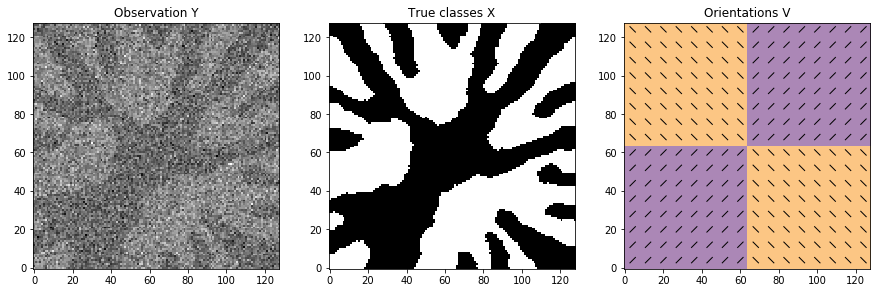

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(131) ; plt.imshow(Y[:,:,0]); plt.title('Observation Y')
plt.subplot(132) ; plt.imshow(X); plt.title('True classes X')
plt.subplot(133) ; plt.imshow(V,cmap=plt.cm.inferno,vmin=0,vmax=np.pi,alpha=0.5); plt.title('Orientations V')
plot_directions(V,8,2)

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  3 09:45:48 2015

@author: courbot
"""





#import gdal

#import spectral.io.envi as envi




#%%
def plot_taux(im,ref,title):
    
    taux = (im!=ref).mean() * 100
    plt.imshow(im.T,  interpolation='nearest', origin='lower', cmap=plt.cm.bone,); 
    plt.title(title + ' - %.2f'%taux)
    plt.axis('off')
    
def erreur(A,B):
    return (A[~np.isnan(B)] != B[~np.isnan(B)] ).mean()
#%%




    
#%%  


#==============================================================================
# Paramètres à fixer
#==============================================================================
# Les valeurs par défaut sont celles-ci:

#nb_iter_sem=40 # nb d'iter maximum pour SEM
#nb_rea = 100 # nombre de realisations de Gibbs differentes pour le MPM
#taille_fen = 5 # fenetre pour la convergence de SEM
#seuil_conv = 0.05 # convergence de SEM
#
#nb_iter_mpm = 100 # longueur max. pour les Gibbs dans le MPM
#pargibbs.nb_iter = 100 
#pargibbs.autoconv=True # convergence automatique des estimateurs de Gibbs
#pargibbs.thr_conv = 5*1./(S0*S1) # seuil pour cette convergence, en relatif
incert = True # Utilisation ou non de segmentation avec incertitude
#pargibbs.Xi = 0.  # valeur de l'"incertitude" adoptee
#tmf = False

parseg = parameters.ParamsSeg(nb_iter_sem=40,
                              seuil_conv = 0.05,
                              incert = incert
                                )
parseg.spec_snr=False #plus tard !
parseg.multi = True # le multiclasse discret
#parseg.seuil_conv = 0.025
#nb_classe = 1
parseg.weights=np.ones(shape=(S0,S1))

parseg.mpm = True

parseg.nb_iter_serie_sem = 13
parseg.use_pi = True
parseg.use_alpha = True

#
#==============================================================================
# Segmentation HMF
#==============================================================================
parseg.tmf = False
#nb_classe = 1
#parseg.seuil_conv = 0.01
pargibbs = parameters.apply_parseg_pargibbs(parseg,pargibbs) # transfetrt a l'autre jeu de parametre
#pargibbs.thr_conv = 10./(128*128)
print '---------------HMF---------------------'
start = time.time()

Y_courant = np.copy(Y)

pargibbs.Y = Y_courant
#pargibbs.X_init = None

X_mpm_hmf,V_mpm_hmf,Ux_hmf,Uv_hmf, parsem_hmf = sot.seg_otmf(parseg,pargibbs)

## 
end = time.time() - start
print 'Temps total : %.2f s'%end  
print '------------------------------------'
#

---------------HMF---------------------


/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/mpm.py:135: RuntimeWarning: divide by zero encountered in divide
  ratios_x = freqs_mpm_x[:,:,np.newaxis]/freqs_marg_x
/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/parameter_estimation.py:432: RuntimeWarning: divide by zero encountered in divide
  ratios = pchaps[np.newaxis,:] / pchaps[:,np.newaxis]
/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/parameter_estimation.py:432: RuntimeWarning: invalid value encountered in divide
  ratios = pchaps[np.newaxis,:] / pchaps[:,np.newaxis]
/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/parameter_estimation.py:435: RuntimeWarning: divide by zero encountered in divide
  correc_en = en[np.newaxis,:] / en[:,np.newaxis]
/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/parameter_estimation.py:435: RuntimeWarning: invalid value encountered in divide
  correc_en = e

Temps total : 133.95 s
------------------------------------


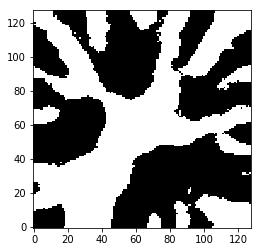

In [8]:
plt.imshow(X_mpm_hmf)

In [ ]:
###
###
###==============================================================================
### Segmentation OTMF
#####==============================================================================
parseg.tmf = True
#parseg.seuil_conv = 0.05
pargibbs = parameters.apply_parseg_pargibbs(parseg,pargibbs) # transfetrt a l'autre jeu de parametre
print '---------------OTMF--------------------'
start = time.time()

Y_courant = np.copy(Y)

#pargibbs.X_init = X_mpm_hmf
pargibbs.Y = Y_courant


X_mpm_est,V_mpm_est,Ux_map,Uv_map, parsem = sot.seg_otmf(parseg,pargibbs)

## 
end = time.time() - start
print 'Temps total : %.2f s'%end  
print '------------------------------------'



#np.savez('/home/miv/courbot/Dropbox/res_sp_cyclone_8cl_mpm',X_mpm_est = X_mpm_est, X_mpm_hmf = X_mpm_hmf, V_mpm_est = V_mpm_est, Y = Y,Ux_map=Ux_map, Ux_hmf=Ux_hmf, Uv_map=Uv_map, parsem = parsem, parsem_hmf = parsem_hmf)


###
#==============================================================================
# Un peu d'adaptation a posteriori si il y a plus que 2 classes
#==============================================================================
##%%
#if x_range.size>2:
#    snr_tous = np.zeros_like(x_range) 
#    # snr estime de la region a 1
#    snr_tous = 10*np.log10((np.linalg.norm(x_range[:,np.newaxis]*parsem.mu[:,0],axis=1)**2) /(W*parsem.sig) )
#
#    X_snr_true = 10*np.log10((np.linalg.norm(X[:,:,np.newaxis]*mu,axis=2)**2) /(W*sig) )
#    
#    # calcul de la RMSE
#    facteur_multiplicatif = np.median(X[X_mpm_est==1]).mean()
#    ecart_moyen = np.abs( (X/5. - X_mpm_est)).mean()
##    rmse = np.sqrt(mse)
#    
##%%
#    
## ce qu'on mesure sur le résultat
#print "Erreur obtenue avec l'estimation"
#facteur = np.mean(X[X_mpm_est==1])
#    
#X_scale = X/facteur
#mse = np.mean((X_scale-X_mpm_est)**2)
#rmse = np.sqrt(mse)
#
#print 'mse: ' + str(mse)
#print 'rmse: ' + str(rmse)
#
## ce qu'on mesure sur une discrétisation de l'image
#print "Erreur obtenue avec la discretisation"
#X_diff = np.abs(X[:,:,np.newaxis] - facteur*x_range[np.newaxis,np.newaxis,:])
##        
#ind_x = np.argmin(X_diff,axis=2)
#X_cast = x_range[ind_x]
#
#mse = np.mean((X_cast-X_mpm_est)**2)
#rmse = np.sqrt(mse)
#
#print 'mse: ' + str(mse)
#print 'rmse: ' + str(rmse)

#%%
#==============================================================================
#   Affichage verite + segmentations
#==============================================================================
import matplotlib

#import cmocean
nb_li = 2
nb_col =4


X,V,dumb = gen_exp(experiment,x_range,S0,S1,W,m,sig,rho_1,rho_2)


cm_gris = matplotlib.cm.gray
cm_angl = matplotlib.cm.Spectral

cm_gris.set_bad('r',1.)
#X_mpm_est[X_mpm_est==0]+=np.nan
cm_angl.set_bad('r',1.)


plt.figure(figsize=(4.5*nb_col,4*nb_li))


plt.subplot(nb_li,nb_col,1)
plt.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=cm_gris)#,vmin = -1,vmax=1); 
#plt.axis('off')
plt.title('$\mathbf{y}$, moyenne spectrale')

plt.subplot(nb_li,nb_col,2)
# on reordonne par intensite
ind_sort = np.argsort(parsem_hmf.mu[:,0])
xr_sort = x_range[::-1]
X_hmf = np.copy(X_mpm_hmf)

#
#im = Y.mean(axis=2)
#for x_inst in x_range:    
#    msk_bon = X_mpm_hmf==x_inst
#    moy_inst = im[msk_bon].mean()
#    X_hmf[msk_bon] = moy_inst#x_range[ind[0]]
#    
#xrn = np.unique(X_hmf)
#msk0 = X_hmf == xrn.min() ;msk1 = X_hmf == xrn.max()
#msk05 = (msk0==0)*(msk1==0)
#
#X_hmf[msk0] = 0. ; X_hmf[msk05] = 0.5 ; X_hmf[msk1] = 1. ;
Xh2 = np.copy(X_hmf)
#Xh2[X_hmf==1]=0.5 
#Xh2[X_hmf==0]=0
#Xh2[X_hmf==0.5]=1
                                                
plt.imshow(1-Xh2, interpolation='nearest', origin='lower', cmap=cm_gris)#,vmin=0,vmax=1); 
plt.title('$\\hat{\mathbf{x}}_{\mathrm{MPM}}$ (HMF) ')

    
plt.subplot(nb_li,nb_col,3)
#X_tmf = np.copy(X_mpm_est)
ind_sort = np.argsort(parsem_hmf.mu[:,0])
xr_sort = x_range[::-1]
X_tmf = np.copy(X_mpm_est)

#
#im = Y.mean(axis=2)
#for x_inst in x_range:    
#    msk_bon = X_mpm_est==x_inst
#    moy_inst = im[msk_bon].mean()
#    ind = np.argsort(np.abs(x_range-moy_inst))
#    msk_est = X_mpm_est==x_inst
#    X_tmf[msk_est] = moy_inst#x_range[ind[0]]
#    
#xrn = np.unique(X_tmf)
#msk0 = X_tmf == xrn.min()
#msk1 = X_tmf == xrn.max()
#msk05 = (msk0==0)*(msk1==0)
#
#X_tmf[msk0] = 0. ; X_tmf[msk05] = 0.5 ; X_tmf[msk1] = 1. ; 
Xt2 = np.copy(X_tmf)
#Xt2[X_tmf==1]=0.33333333 
#Xt2[(X_tmf >0.3) * (X_tmf < 0.4)]=1
Xt2[X_tmf==0]=1
Xt2[X_tmf==1]=0.5
Xt2[X_tmf==0.5]=0.

plt.imshow(Xt2, interpolation='nearest', origin='lower', cmap=cm_gris)#,vmin=0,vmax=1); 
plt.title('$\\hat{\mathbf{x}}_{\mathrm{MPM}}$ ')


plt.subplot(nb_li,nb_col,4)
#plt.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=cm_gris);
plt.imshow(V_mpm_est, interpolation='nearest', origin='lower', cmap=cm_angl,vmin=0,vmax=np.pi); 
#plt.imshow(X_mpm_est, interpolation='nearest', origin='lower', cmap=cm_gris,alpha=0.5);
plot_directions(V_mpm_est, np.ones_like(V_mpm_est),pas=4,taille=1.5)

#
#plt.subplot(nb_li,nb_col,6)
#plt.imshow(Ux_hmf, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin=0,vmax=1); 
#plt.title('$\\hat{\mathbf{u}}^x$ HMF')
#plt.colorbar(fraction=0.046,pad=0.04)
#  
#plt.subplot(nb_li,nb_col,7)
#plt.imshow(Ux_map, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin=0,vmax=1); 
#plt.title('$\\hat{\mathbf{u}}^x$')
#plt.colorbar(fraction=0.046,pad=0.04)
#
#
#plt.subplot(nb_li,nb_col,8)
#plt.imshow(Uv_map, interpolation='nearest', origin='lower',cmap=plt.cm.gray,vmin=0, vmax=1); 
#plt.colorbar(fraction=0.046,pad=0.04)
#plt.title('$\\hat{\mathbf{u}}^v$')


plt.tight_layout()

#np.savez('./results/res_pami_mars2',X_mpm_est = X_tmf, X_mpm_hmf = X_hmf, V_mpm_est = V_mpm_est, Y = Y,Ux_map=Ux_map, Ux_hmf=Ux_hmf, Uv_map=Uv_map, parsem = parsem, parsem_hmf = parsem_hmf)
###

#np.savez('./results/res_pami_vine(map)',X_mpm_est = X_tmf, X_mpm_hmf = X_hmf, V_mpm_est = V_mpm_est, Y = Y,Ux_map=Ux_map, Ux_hmf=Ux_hmf, Uv_map=Uv_map, parsem = parsem, parsem_hmf = parsem_hmf)
#

#%% Comparaison X vrai et segmente
if  (X_hmf != X).mean() > 0.5:
    X_hmf =  1. - X_hmf
    
if  (X_tmf != X).mean() > 0.5:
    X_tmf =  1. - X_tmf
    
    
Ex_hmf = (X_hmf != X).mean()
#Ex_hmf = Ex_hmf*(Ex_hmf < 0.5) + (1-Ex_hmf)*(Ex_hmf > 0.5)

Ex_tmf = (X_tmf != X).mean()
#Ex_tmf = Ex_tmf*(Ex_tmf < 0.5) + (1-Ex_tmf)*(Ex_tmf > 0.5)



#RMSE_hmf = np.sqrt( np.mean( (X_hmf-X)**2 ) )
##RMSE_hmf = RMSE_hmf*(RMSE_hmf < 0.5) + (1-RMSE_hmf)*(RMSE_hmf > 0.5)
#
#RMSE_tmf = np.sqrt( np.mean( (X_tmf-X)**2 ) )
##RMSE_tmf = RMSE_tmf*(RMSE_tmf < 0.5) + (1-RMSE_tmf)*(RMSE_tmf > 0.5)
#
#moy_ux_hmf = np.mean(Ux_hmf[Ux_hmf<=1])
#moy_ux_tmf = np.mean(Ux_map[Ux_map<=1])
#
#std_ux_hmf = np.std(Ux_hmf[Ux_hmf<=1])
#std_ux_tmf = np.std(Ux_map[Ux_map<=1])
#%%
print 'Taux erreur HMF : %.7f, taux erreur TMF : %.7f'%(Ex_hmf*100,Ex_tmf*100)
#print 'RMSE HMF :        %.7f, RMSE TMF :        %.7f'%(RMSE_hmf,RMSE_tmf)
#print 'moy(ux) HMF :     %.7f, moy(ux) TMF :     %.7f'%(moy_ux_hmf , moy_ux_tmf)
#print 'std(ux) HMF :     %.7f, std(ux) TMF :     %.7f'%(std_ux_hmf , std_ux_tmf)


#%%
#plt.figure(figsize=(10,10))
#plt.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=cm_gris);#plt.imshow(V_mpm_est, interpolation='nearest', origin='lower', cmap=cm_angl,vmin=0,vmax=np.pi); 
##plt.imshow(X_mpm_est, interpolation='nearest', origin='lower', cmap=cm_gris,alpha=0.5);
#plot_directions(V_mpm_est, np.ones_like(V_mpm_est),pas=4,taille=1.5)
#%%
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=plt.cm.Greys_r,vmin = -1,vmax=1); 
#plt.axis('off')
#plt.savefig('./figures/exp_pamiBy.png', format='png',dpi=200)
#
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(1-X_mpm_est, interpolation='nearest', origin='lower', cmap=plt.cm.Greys_r)#,vmin = -1,vmax=1); 
#plt.axis('off')
#plt.savefig('./figures/exp_pamiBx_otmf.png', format='png',dpi=200)
##
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(1-X_mpm_hmf, interpolation='nearest', origin='lower', cmap=plt.cm.Greys_r)#,vmin = -1,vmax=1); 
#plt.axis('off')
#plt.savefig('./figures/exp_pamiBx_hmf.png', format='png',dpi=200)
#
#
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(V_mpm_est, interpolation='nearest', origin='lower', cmap=plt.cm.Spectral,alpha=0.25,vmin=0,vmax=np.pi);#plt.imshow(V_mpm_est, interpolation='nearest', origin='lower', cmap=cm_angl,vmin=0,vmax=np.pi); 
#plot_directions(V_mpm_est, np.ones_like(V_mpm_est),pas=4,taille=1.0)
#plt.axis('off')
#plt.savefig('./figures/exp_pamiBv_otmf.png', format='png',dpi=200)


#
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(Ux_map, interpolation='nearest', origin='lower', cmap=plt.cm.Greys_r,vmin =0,vmax=1); 
#plt.axis('off')
#plt.savefig('./figures/exp_pamiB_ux.png', format='png',dpi=200)
##
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(Uv_map, interpolation='nearest', origin='lower', cmap=plt.cm.Greys_r,vmin = 0,vmax=1); 
#plt.axis('off')
#plt.savefig('./figures/exp_pamiB_uv.png', format='png',dpi=200)
#
#plt.close('all')



#%%

#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#im = Y.mean(axis=2)
#ax.imshow(im, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin = im.mean() - 3*im.std(), vmax = im.mean() + 3*im.std())#,vmin = -1,vmax=1); 
#plt.axis('off')
#plt.savefig('./figures/vine2a.png', format='png',dpi=200)
#
#
##%%
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(X_tmf, interpolation='nearest', origin='lower', cmap=plt.cm.Greys,vmin=0); 
#plt.axis('off')
#plt.savefig('./figures/vine2b.png', format='png',dpi=200)
#
##%%
#
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(Ux_map, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin=0,vmax=1); 
#plt.axis('off')
#plt.savefig('./figures/vine2c.png', format='png',dpi=200)
##%%
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(1-X_hmf, interpolation='nearest', origin='lower', cmap=plt.cm.Greys,vmin=0); 
#plt.axis('off')
#plt.savefig('./figures/vine2d.png', format='png',dpi=200)
#
##%%
#plt.close('all')
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
##ax.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=plt.cm.gray,alpha=0.25);#plt.imshow(V_mpm_est, interpolation='nearest', origin='lower', cmap=cm_angl,vmin=0,vmax=np.pi); 
#ax.imshow(V_mpm_est, vmin=0, vmax=np.pi,interpolation='nearest', origin='lower',cmap=plt.cm.hsv_r,alpha=0.25)
#plot_directions(V_mpm_est, np.ones_like(V_mpm_est),pas=4,taille=1.5)
#plt.axis('off')
#plt.savefig('./figures/vine2e.png', format='png',dpi=200)
#
##%%
#fig = plt.figure(figsize=(6,6))
#ax = plt.Axes(fig, [0.,0.,1.,1.])
#fig.add_axes(ax)
#ax.imshow(Uv_map, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin=0,vmax=1); 
#plt.axis('off')
#plt.savefig('./figures/vine2f.png', format='png',dpi=200)
##
##%%

#%%
#
#if x_range.size>2:
#    snr_tous = np.zeros_like(x_range) 
#    # snr estime de la region a 1
#    snr_tous = 10*np.log10((np.linalg.norm(x_range[:,np.newaxis]*parsem.mu[:,0],axis=1)**2) /(W*parsem.sig) )   
#
##plt.close('all')
#nb_li = 3
#nb_col =3
##
##plt.rc('text', usetex=True)
##plt.rc('font',family='serif')
#
#
#
#cm_gris = matplotlib.cm.gray
#cm_angl = matplotlib.cm.Spectral
#
#cm_gris.set_bad('r',1.)
##X_mpm_est[X_mpm_est==0]+=np.nan
#cm_angl.set_bad('r',1.)
###cm_gris = matplotlib.cm.gray
###cm_angl = matplotlib.cm.Spectral
##
##cm_gris.set_bad('r',1.)
##cm_angl.set_bad('r',1.)
#
#plt.figure(figsize=(4.5*nb_col,4*nb_li))
#
#
#plt.subplot(nb_li,nb_col,1)
#plt.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=cm_gris)#,vmin = -1,vmax=1); 
##plt.axis('off')
#plt.title('$\mathbf{y}$, moyenne spectrale')
#
#plt.subplot(nb_li,nb_col,2)
#plt.imshow(X, interpolation='nearest', origin='lower', cmap=cm_gris,vmin=0); 
##plt.contour(V, v_range.size,colors='g',linewidths=2,alpha=0.75)
##plt.axis('off')
#plt.title('$\mathbf{x}$')
#
#plt.subplot(nb_li,nb_col,3)
#plt.imshow(V, interpolation='nearest', origin='lower', cmap=cm_angl,vmin=0,vmax=np.pi); 
#plot_directions(V, np.ones_like(V),pas=8)
##plt.axis('off')
#plt.title('$\mathbf{v}$')
#
#
#
#
#    
#plt.subplot(nb_li,nb_col,nb_col+2)
#if x_range.size>2:
##    cm_gris_snr = matplotlib.cm.get_cmap('gray',nb_level_x+1)
##    cm_gris_snr.set_bad('w',1.)
##    bounds = snr_tous[~np.isinf(snr_tous)]
#    plt.imshow(X_mpm_est, interpolation='nearest', origin='lower', cmap=cm_gris,vmin=0,vmax=1); 
##            loc = x_range*(nb_level_x-1)/(nb_level_x) #+0.5/(nb_level_x)
##    loc = np.linspace(0.5/nb_level_x,1-0.5/nb_level_x,nb_level_x+1)
###            loc = 0.5/nb_level_x + np.arange(nb_level_x)/float(nb_level_x)
##    cb=plt.colorbar(fraction=0.046,pad=0.04,aspect='auto',shrink=float(S1)/S0)
##    cb.set_ticks(loc)
##    cb.set_label('SNR')
##    cb.set_ticklabels(['{:4.2f}'.format(l) for l in bounds])
#else:
#    plt.imshow(X_mpm_est, interpolation='nearest', origin='lower', cmap=cm_gris,vmin=0,vmax=1); 
##for vr in range(v_range.size):
##    plt.contour(V_mpm_hierarch[:,:,level]==v_range[vr],1,colors='g',linewidths=2,alpha=0.75)
##plt.axis('off')
##    plt.title('$\\hat{\mathbf{x}}_{MPM}^%.0f$'%level)
##erreur_mpm_x = (X != X_mpm_est).mean()
#plt.title('$\\hat{\mathbf{x}}_{\mathrm{MPM}}$ - %.2f '%(erreur(X,X_mpm_est)*100))
#
#
#plt.subplot(nb_li,nb_col,nb_col+3)
#plt.imshow(V_mpm_est, interpolation='nearest', origin='lower',cmap=cm_angl,vmin=0,vmax=np.pi); 
#plot_directions(V_mpm_est, np.ones_like(V_mpm_est),pas=8)
##plt.axis('off')
#plt.title('$\\hat{\mathbf{v}}_{\mathrm{MPM}}$ - %.2f '%(erreur(V,V_mpm_est)*100))
#
#
#if incert==True:
#    
#    
#    plt.subplot(nb_li,nb_col,2*nb_col+2)
#    plt.imshow(Ux_map, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin=0,vmax=1); 
#    #plt.axis('off')
#    plt.title('$\\hat{\mathbf{u}}^x$')
#    plt.colorbar(fraction=0.046,pad=0.04)
#    
#    
#    plt.subplot(nb_li,nb_col,2*nb_col+3)
#    plt.imshow(Uv_map, interpolation='nearest', origin='lower',cmap=plt.cm.gray,vmin=0, vmax=1); 
#    plt.colorbar(fraction=0.046,pad=0.04)
#    #plt.axis('off')
#    plt.title('$\\hat{\mathbf{u}}^v$')
#
#
#plt.tight_layout()


#%% let us plot images from earth
#
#plt.figure(figsize=(6,6))
#plt.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=plt.cm.terrain)#,vmin = -1,vmax=1); 
#plt.axis('off')
#plt.tight_layout()
##plt.xlim(.50,79.5)
##plt.ylim(0.50,79.5)
#plt.savefig('./figures/vine2a.png', format='png',dpi=200)
#
#plt.figure(figsize=(6,6))
#plt.imshow(X_mpm_est, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin=0); 
##plt.xlim(.50,79.5)
##plt.ylim(0.50,79.5)
#plt.axis('off')
#plt.tight_layout()
#plt.savefig('./figures/vine2b.png', format='png',dpi=200)
#
##f4 = plt.figure(figsize=(6,6))
#data = Y.mean(axis=2)
#sizes = np.shape(data)
#height = float(sizes[0])
#width = float(sizes[1])
#
#fig = plt.figure(figsize=(6,6))
#plt.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=plt.cm.terrain,alpha=0.5);#plt.imshow(V_mpm_est, interpolation='nearest', origin='lower', cmap=cm_angl,vmin=0,vmax=np.pi); 
#plot_directions(V_mpm_est, np.ones_like(V_mpm_est),pas=2,taille=0.75)
##plt.xlim(.50,79.5)
##plt.ylim(0.50,79.5)
#plt.axis('off')
#plt.tight_layout()
#plt.savefig('./figures/vine2e.png', format='png',dpi=200)
#
#
#fig = plt.figure(figsize=(6,6))
#plt.imshow(Ux_map, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin=0,vmax=1); 
#plt.axis('off')
#plt.tight_layout()
#plt.savefig('./figures/vine2c.png', format='png',dpi=200)
#
#fig = plt.figure(figsize=(6,6))
#plt.imshow(Uv_map, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin=0,vmax=1); 
#plt.axis('off')
#plt.tight_layout()
#plt.savefig('./figures/vine2f.png', format='png',dpi=200)

#%%
##%% let us plot images from mars
#plt.figure(figsize=(9,3))
#
#
#
#plt.subplot(131)
#plt.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=plt.cm.copper_r)#,vmin = -1,vmax=1); 
##plt.axis('off')
#plt.title('$Y = y$')
#plt.xlim(.50,79.5)
#plt.ylim(0.50,79.5)
#
#plt.subplot(132)
#plt.imshow(X_mpm_est, interpolation='nearest', origin='lower', cmap=plt.cm.gray,vmin=0); 
##plt.contour(V, v_range.size,colors='g',linewidths=2,alpha=0.75)
##plt.axis('off')
#plt.title('$\\hat{x}^{\mathrm{MPM}}$')
#plt.xlim(.50,79.5)
#plt.ylim(0.50,79.5)
#
#plt.subplot(133)
#plt.imshow(Y.mean(axis=2), interpolation='nearest', origin='lower', cmap=plt.cm.copper_r,vmin=0,alpha=0.5);#plt.imshow(V_mpm_est, interpolation='nearest', origin='lower', cmap=cm_angl,vmin=0,vmax=np.pi); 
#plot_directions(V_mpm_est, np.ones_like(V_mpm_est),pas=2,taille=0.75)
#plt.xlim(.50,79.5)
#plt.ylim(0.50,79.5)
#plt.title('$\\hat{v}^{\mathrm{MPM}}$')
#
#plt.tight_layout()
#plt.savefig('./figures/mars1.png', format='png',dpi=200)
#%%
#
#
#X_tpm_est = X_mpm.mean(axis=2)
#V_tpm_est  =V_mpm.sum(axis=2)
#
#plt.subplot(nb_li,nb_col,2*nb_col+2)
#plt.imshow(X_tpm_est, interpolation='nearest', origin='lower', cmap=cm_gris,vmin=0,vmax=1); 
#plt.title('$\\hat{\mathbf{x}}_{\mathrm{TPM}}$ ')
#
#
#plt.subplot(nb_li,nb_col,2*nb_col+3)
#plt.imshow(V_tpm_est, interpolation='nearest', origin='lower',cmap=cm_angl,vmin=0,vmax=np.pi); 
#plot_directions(V_tpm_est, np.ones_like(V_tpm_est),pas=8)
#plt.axis('off')


#plt.savefig('./figures/galtout.png', format='png',dpi=200)

#%%
#
#plt.figure(figsize=(4.5*3,4))
#
#X_tpm_est = X_mpm.mean(axis=2)
#V_tpm_est  =V_mpm.mean(axis=2)%np.pi
#
#ecart_x = np.abs(X_tpm_est-X/5.)
#
#plt.subplot(131)
#plt.imshow(X_tpm_est, interpolation='nearest', origin='lower', cmap=cm_gris,vmin=0,vmax=1); 
#plt.title('$\\hat{\mathbf{x}}_{\mathrm{TPM}}$ ')
#
#plt.subplot(132)
#plt.imshow(ecart_x, interpolation='nearest', origin='lower', cmap=cm_gris,vmin=0,vmax=1); 
#plt.title('ecart absolu')
#
#plt.subplot(133)
#plt.imshow(V_tpm_est, interpolation='nearest', origin='lower',cmap=cm_angl,vmin=0,vmax=np.pi); 
#plot_directions(V_tpm_est, np.ones_like(V_tpm_est),pas=8)
#plt.title('$\\hat{\mathbf{v}}_{\mathrm{TPM}}$ ')
##plt.axis('off')
#
#plt.tight_layout()

#%%
#from mpl_toolkits.mplot3d import Axes3D
#
#fig = plt.figure()
#ax = fig.gca(projection='3d')
#
#
#X = np.arange(0,S0,1)
#Y = np.arange(0,S1,1)
#X,Y = np.meshgrid(X,Y)
#surf = ax.plot_surface(X,Y,ecart_x,cmap=plt.cm.coolwarm)
#ax.set_zlim(0,1)
#
#plt.show()

#%%
#